# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).

![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Calibrating and synthetic simulations of Rainfall with the STNSRPM.


In this script we calibrate the STNSRPM (Spatio Temporal Neyman Scott Rectangular Pulse Model) using several rainfall series from Tenerife Island with a semi-arid climate (BSh-BSk). The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other things.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

### Load packages

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
import tqdm

In [47]:
import math as mt
from datetime import date
from datetime import timedelta
from scipy import stats

In [48]:
import sys
sys.path.insert(1, '../NEOPRENE/')

In [49]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.utils import compare_statistics, datetime2matlabdnJavi 
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min
from NEOPRENE.NSRP.Simulation import Simulation as Simulation_NSRP
from NEOPRENE.STNSRP.Simulation import Simulation

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
import time
start_time = time.time()

### Loading daily rainfall for Tenerife Island (now for Sierra Nevada)

__Cuidado que las series tienen que ser coetáneas en el tiempo__

In [52]:
path_1 = './auxiliary-materials/SN/'

In [53]:
## Loading rainfall series
Series_SN = pd.read_csv(path_1 + 'DailySN.csv', index_col=0, parse_dates=True)
Series_SN[Series_SN.values<0]=np.nan
Input_Series=Series_SN.copy()
del Series_SN

In [54]:
## Loading attributes for the series
Attributes_SN = pd.read_csv(path_1 + 'AtributosSN.csv', index_col=0)
Input_Attr=pd.DataFrame()

from pyproj import Proj, transform
outProj = Proj(init='epsg:25830')
inProj = Proj(init='epsg:4326')
x2,y2 = transform(inProj,outProj,Attributes_SN.Long.values.astype(float),Attributes_SN.Lat.values.astype(float))

Input_Attr['ID']=[str(i) for i in Attributes_SN.field_1.values]
Input_Attr['X']=x2
Input_Attr['Y']=y2
Input_Attr['Elevation']=Attributes_SN.field_4.values

In [55]:
Input_Attr = Input_Attr.iloc[0:5]

In [56]:
## Shorting ID series to match with Input_Attr
Input_Series = Input_Series[Input_Attr.ID]

<AxesSubplot:>

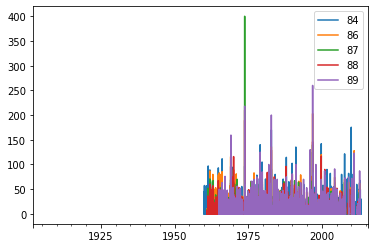

In [43]:
Input_Series.plot()

### Plotting rainfall series, seasonality and gauge position

Text(0, 0.5, 'mm/month')

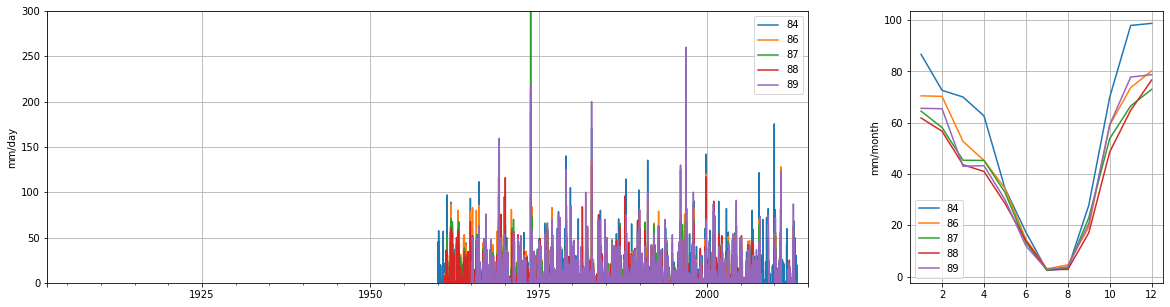

In [14]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Series.index.year[0]); t2=str(Input_Series.index.year[-1])
Input_Series.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Series.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Series>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

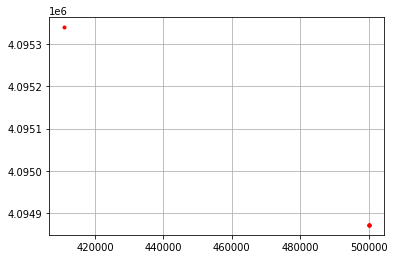

In [15]:
plt.plot(Input_Attr.X, Input_Attr.Y, '.r')
plt.grid()

### Calibration

Compleate...

In [16]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_SN.yml')

In [17]:
# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series, attributes = Input_Attr)

# Input statistics from file 
#statistics_model_2 = Statistics(hiper_params_cal, file = 'auxiliary-materials/statististics_Bilbao.csv')

In [18]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, Input_Series, verbose=True)
CAL1.save_files('./CAL_SN/')#save python objects

[20, 1000]


################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)



Fitting the months = (1, 2, 3)

Initialization number  = 0
Initial best position  4.62010191604062 [5.64545370e-02 7.73115273e+01 1.22228021e+03 9.48693995e-01
 1.63508292e+00]
Iteration number  = 0
Total error = 4.62010191604062
Iteration number  = 1
Total error = 4.62010191604062
Iteration number  = 2
Total error = 3.155101689090484
Iteration number  = 3
Total error = 2.359489046798074
Iteration number  = 4
Total error = 2.359489046798074
Iteration number  = 5
Total error = 1.9174908029122768
Iteration number  = 6
Total error = 1.9174908029122768
Iteration number  = 7
Total error = 1.9174908029122768
Iteration number  = 8
Total error = 1.9174908029122768
Iteration number  = 9
Total error = 1.8456680578026043
Iteration number  = 10
Total error = 1.7773810568846964
Iteration number  = 11
Total error = 1.6884787915286594
It

In [57]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_SN.yml')

In [58]:
SIM              = Simulation(hiper_params_sim) 
# Input parameters from the model

# SIM1             = SIM(params_cal = CAL1, Input_Series = Input_Series, Input_Attr = Input_Attr)

SIM1             = SIM(params_cal =['./CAL_SN/Calibrated_parameters.csv',
                                    './CAL_SN/xi_months.csv'], 
                       Input_Series = Input_Series, Input_Attr = Input_Attr)



################################################################################
Synthetic simulation


[423045.9803146841, 4069129.7964434964]
[495750.2827302703, 4069129.7964434964]
[495750.2827302703, 4107169.5329131754]
[423045.9803146841, 4107169.5329131754]
72.7043024155862
38.03973646967905
2765.652504100749
[0.02397881 0.02397881 0.02397881 0.14508948 0.14508948 0.14508948
 0.10690018 0.10690018 0.10690018 0.17892069 0.17892069 0.17892069] Celdas por km² y por tormenta
[ 66.31705707  66.31705707  66.31705707 401.2670746  401.2670746
 401.2670746  295.64873693 295.64873693 295.64873693 494.83246429
 494.83246429 494.83246429] Celdas por tormenta en mi area de simulacion
Storm ini = [22.1434231  22.1434231  22.1434231  20.77963809 20.77963809 20.77963809
 41.66666667 41.66666667 41.66666667 35.51134435 35.51134435 35.51134435]
Numero de tormentas 39 para los meses [1]
Numero de celdas de lluvia por tormenta 67.23076923076923


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.38it/s]


Numero de tormentas 52 para los meses [2]
Numero de celdas de lluvia por tormenta 69.3076923076923


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 27.66it/s]


Numero de tormentas 46 para los meses [3]
Numero de celdas de lluvia por tormenta 66.54347826086956


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 28.90it/s]


Numero de tormentas 41 para los meses [4]
Numero de celdas de lluvia por tormenta 401.4146341463415


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:08<00:00,  4.81it/s]


<AxesSubplot:>

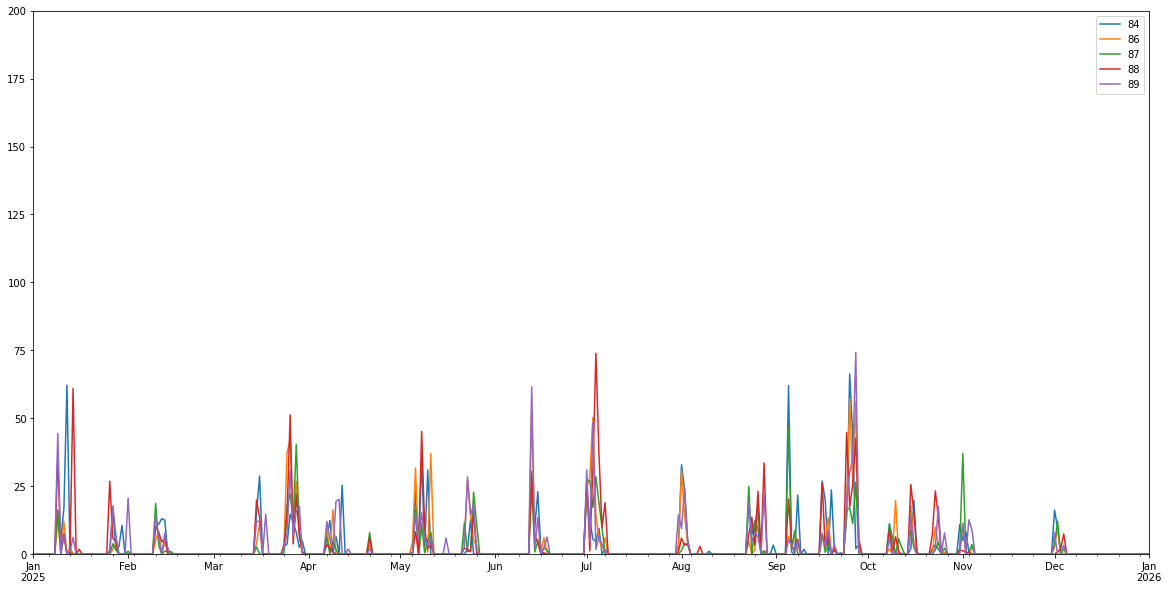

In [59]:
SIM1.Daily_Simulation.plot(figsize=(20, 10), xlim=['2025-01-01', '2026-01-01'], ylim=[0, 200])

In [60]:
Input_Series.astype(float).corr()

,84,86,87,88,89
84,1.000000,0.699149,0.667550,0.531197,0.711733
86,0.699149,1.000000,0.759064,0.576975,0.784716
87,0.667550,0.759064,1.000000,0.601514,0.700415
88,0.531197,0.576975,0.601514,1.000000,0.525194
89,0.711733,0.784716,0.700415,0.525194,1.000000


In [61]:
SIM1.Daily_Simulation.astype(float).corr()

,84,86,87,88,89
84,1.000000,0.428599,0.487286,0.445059,0.465554
86,0.428599,1.000000,0.668709,0.557854,0.608949
87,0.487286,0.668709,1.000000,0.615690,0.622570
88,0.445059,0.557854,0.615690,1.000000,0.599096
89,0.465554,0.608949,0.622570,0.599096,1.000000


In [ ]:
SIM1.crosscorr_Simulated

In [ ]:
SIM1.save_files('./SIM_SN/')

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))